In [72]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_curve, roc_auc_score, auc, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from plotnine import *

# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [4]:
# !pip install palmerpenguins
from palmerpenguins import load_penguins
penguins = load_penguins()
penguins.dropna(inplace=True)
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [60]:
X = penguins.drop(["species"], axis = 1)
y = penguins["species"]

# Define classes for multi-class binarization
classes = np.unique(y)

# Binarize the target variable
y_binarized = label_binarize(y, classes=classes)

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

# Binarize the target variable for AUC calculation after splitting
y_train_binarized = label_binarize(y_train, classes=classes)
y_test_binarized = label_binarize(y_test, classes=classes)

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop='first'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

penguins_pipeline = Pipeline([
        ("preprocessing", ct)]
)

penguins_pipeline.fit(X)

X_preprocess = penguins_pipeline.named_steps["preprocessing"].transform(X)
transformed_df = pd.DataFrame(X_preprocess, columns=penguins_pipeline.named_steps["preprocessing"].get_feature_names_out())
transformed_df

,dummify__island_Dream,dummify__island_Torgersen,dummify__sex_male,standardize__bill_length_mm,standardize__bill_depth_mm,standardize__flipper_length_mm,standardize__body_mass_g,standardize__year
0,0.0,1.0,1.0,-0.896042,0.780732,-1.426752,-0.568475,-1.283742
1,0.0,1.0,0.0,-0.822788,0.119584,-1.069474,-0.506286,-1.283742
2,0.0,1.0,0.0,-0.676280,0.424729,-0.426373,-1.190361,-1.283742
3,0.0,1.0,0.0,-1.335566,1.085877,-0.569284,-0.941606,-1.283742
4,0.0,1.0,1.0,-0.859415,1.747026,-0.783651,-0.692852,-1.283742
...,...,...,...,...,...,...,...,...
328,1.0,0.0,1.0,2.162314,1.340165,0.431094,-0.257532,1.180155
329,1.0,0.0,0.0,-0.090248,0.475587,0.073816,-1.003795,1.180155
330,1.0,0.0,1.0,1.026876,0.526444,-0.569284,-0.537380,1.180155
331,1.0,0.0,1.0,1.246638,0.933305,0.645461,-0.133155,1.180155


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

Overall Accuracy (K=3): 0.9800
              precision    recall  f1-score   support

      Adelie       0.96      1.00      0.98        44
   Chinstrap       1.00      0.90      0.95        20
      Gentoo       1.00      1.00      1.00        36

    accuracy                           0.98       100
   macro avg       0.99      0.97      0.98       100
weighted avg       0.98      0.98      0.98       100

AUC for Each Class:
  Adelie: 0.9996
  Chinstrap: 0.9994
  Gentoo: 1.0000


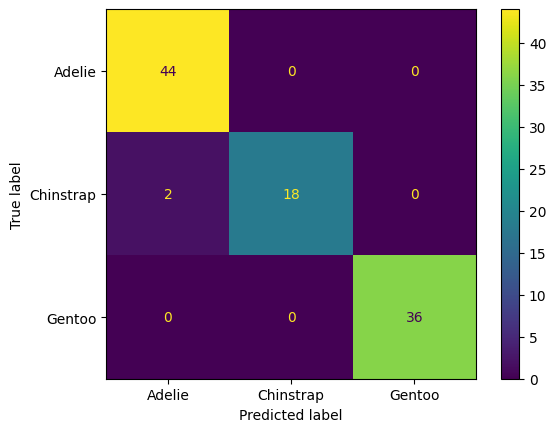

In [83]:
# Model 1: kNN Model where K = 3
# Split the data (with stratification)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Define pipeline
knn3_pipeline = Pipeline([
    ("preprocessing", ct),
    ("knn3", KNeighborsClassifier(n_neighbors=3))
]).set_output(transform="pandas")

# Fit the pipeline on the training data
knn3_pipeline.fit(X_train, y_train)

# Make predictions and probabilities
y_pred_knn3 = knn3_pipeline.predict(X_test)
y_prob_test_knn3 = knn3_pipeline.predict_proba(X_test)

# Calculate Confusion Matrix
knn3_cm = confusion_matrix(y_test, y_pred_knn3)
ConfusionMatrixDisplay(confusion_matrix=knn3_cm, display_labels=classes).plot()

# Calculate Overall Accuracy
knn3_accuracy = accuracy_score(y_test, y_pred_knn3)
print(f"Overall Accuracy (K=3): {knn3_accuracy:.4f}")

# Calculate Precision, Recall, F1-Score for Each Class
print(classification_report(y_test, y_pred_knn3))

# Binarize the test labels for AUC
y_test_binarized = label_binarize(y_test, classes=np.unique(y))

# Calculate AUC for each class
print("AUC for Each Class:")
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob_test_knn3[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"  {class_name}: {roc_auc:.4f}")

Overall Accuracy (K=5): 0.9900
              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        44
   Chinstrap       1.00      0.95      0.97        20
      Gentoo       1.00      1.00      1.00        36

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100

AUC for Each Class:
  Adelie: 1.0000
  Chinstrap: 1.0000
  Gentoo: 1.0000


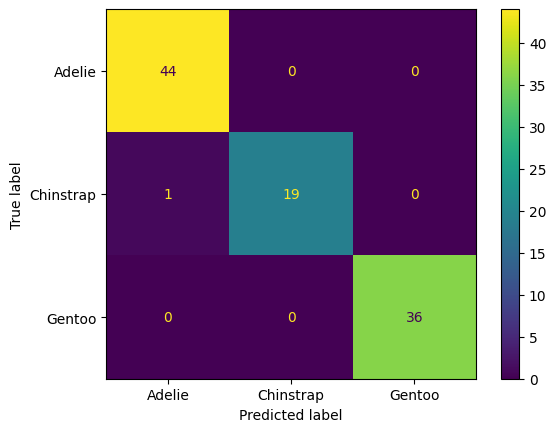

In [84]:
# Model 2: kNN Model where K = 5

# Split the data (with stratification)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Define pipeline for k=5
knn5_pipeline = Pipeline([
    ("preprocessing", ct),
    ("knn5", KNeighborsClassifier(n_neighbors=5))
]).set_output(transform="pandas")

# Fit the pipeline on the training data
knn5_pipeline.fit(X_train, y_train)

# Predictions and probabilities
y_pred_knn5 = knn5_pipeline.predict(X_test)
y_prob_test_knn5 = knn5_pipeline.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_knn5)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot()

# Accuracy
accuracy = accuracy_score(y_test, y_pred_knn5 )
print(f"Overall Accuracy (K=5): {accuracy:.4f}")

# Classification report
print(classification_report(y_test, y_pred_knn5 ))

# Binarize the test labels for AUC
y_test_binarized = label_binarize(y_test, classes=np.unique(y))

# AUC for each class
print("AUC for Each Class:")
for i, class_name in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob_test_knn5[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"  {class_name}: {roc_auc:.4f}")

Overall Accuracy (DT1): 0.97
              precision    recall  f1-score   support

      Adelie       0.94      1.00      0.97        44
   Chinstrap       1.00      0.85      0.92        20
      Gentoo       1.00      1.00      1.00        36

    accuracy                           0.97       100
   macro avg       0.98      0.95      0.96       100
weighted avg       0.97      0.97      0.97       100

AUC for Each Class (DT1):
  Adelie: 0.98
  Chinstrap: 0.95
  Gentoo: 1.00


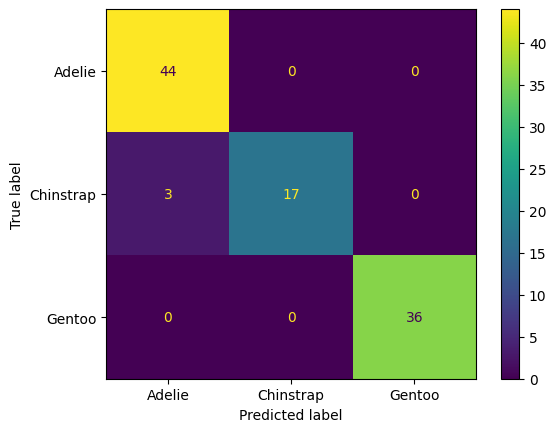

In [74]:
# Model 3: Decision Tree (Low Complexity)
dt1_pipeline = Pipeline([
    ("preprocessing", ct),
    ("dt1", DecisionTreeClassifier(max_depth=3, random_state=1))  # Low complexity
]).set_output(transform="pandas")

# Fit the pipeline on the training data
dt1_pipeline.fit(X_train, y_train)

# Make predictions and probabilities
y_pred_dt1 = dt1_pipeline.predict(X_test)
y_prob_dt1 = dt1_pipeline.predict_proba(X_test)

# Calculate Confusion Matrix
dt1_cm = confusion_matrix(y_test, y_pred_dt1)
ConfusionMatrixDisplay(confusion_matrix=dt1_cm, display_labels=classes).plot()

# Calculate Overall Accuracy
dt1_accuracy = accuracy_score(y_test, y_pred_dt1)
print(f"Overall Accuracy (DT1): {dt1_accuracy:.2f}")

# Calculate Precision, Recall, F1-Score for Each Class
print(classification_report(y_test, y_pred_dt1, target_names=classes))

# Binarize the target for AUC calculation
y_test_binarized_dt1 = label_binarize(y_test, classes=classes)

# Calculate AUC for each class
print("AUC for Each Class (DT1):")
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized_dt1[:, i], y_prob_dt1[:, i])
    roc_auc_dt1 = auc(fpr, tpr)
    print(f"  {class_name}: {roc_auc_dt1:.2f}")



Overall Accuracy (DT2): 0.98
              precision    recall  f1-score   support

      Adelie       0.96      1.00      0.98        44
   Chinstrap       1.00      0.90      0.95        20
      Gentoo       1.00      1.00      1.00        36

    accuracy                           0.98       100
   macro avg       0.99      0.97      0.98       100
weighted avg       0.98      0.98      0.98       100

AUC for Each Class (DT2):
  Adelie: 0.98
  Chinstrap: 0.95
  Gentoo: 1.00


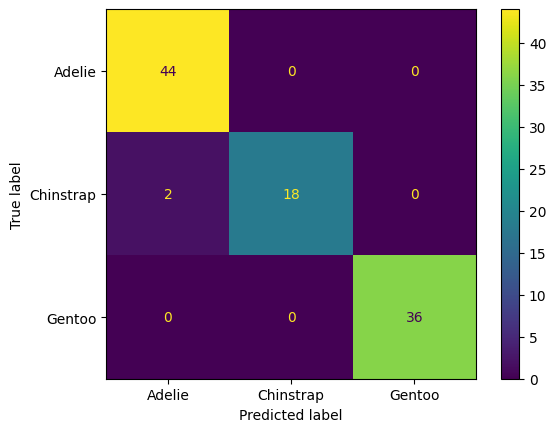

In [75]:
# Model 4: Decision Tree (Higher Complexity)

dt2_pipeline = Pipeline([
    ("preprocessing", ct),
    ("dt2", DecisionTreeClassifier(max_depth=None, random_state=1))  # Higher complexity (unrestricted depth)
]).set_output(transform="pandas")

# Fit the pipeline on the training data
dt2_pipeline.fit(X_train, y_train)

# Make predictions and probabilities
y_pred_dt2 = dt2_pipeline.predict(X_test)
y_prob_dt2 = dt2_pipeline.predict_proba(X_test)

# Calculate Confusion Matrix
dt2_cm = confusion_matrix(y_test, y_pred_dt2)
ConfusionMatrixDisplay(confusion_matrix=dt2_cm, display_labels=classes).plot()

# Calculate Overall Accuracy
dt2_accuracy = accuracy_score(y_test, y_pred_dt2)
print(f"Overall Accuracy (DT2): {dt2_accuracy:.2f}")

# Calculate Precision, Recall, F1-Score for Each Class
print(classification_report(y_test, y_pred_dt2, target_names=classes))

# Binarize the target for AUC calculation
y_test_binarized_dt2 = label_binarize(y_test, classes=classes)

# Calculate AUC for each class
print("AUC for Each Class (DT2):")
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized_dt2[:, i], y_prob_dt2[:, i])
    roc_auc_dt2 = auc(fpr, tpr)
    print(f"  {class_name}: {roc_auc_dt2:.2f}")


The results indicate that all models achieved high accuracy in predicting the penguin species. The kNN models with k=3 and k=5 performed similarly well, with accuracy values of 0.98 and 0.99, respectively. The decision tree models also delivered strong performance, with accuracies of 0.97 and 0.98, depending on the tree complexity. Across all models, precision, recall, and F1-scores were consistently high for each species, demonstrating reliable classification. However, slight differences in metrics for the Chinstrap class suggest some sensitivity to model parameters like k or tree depth.

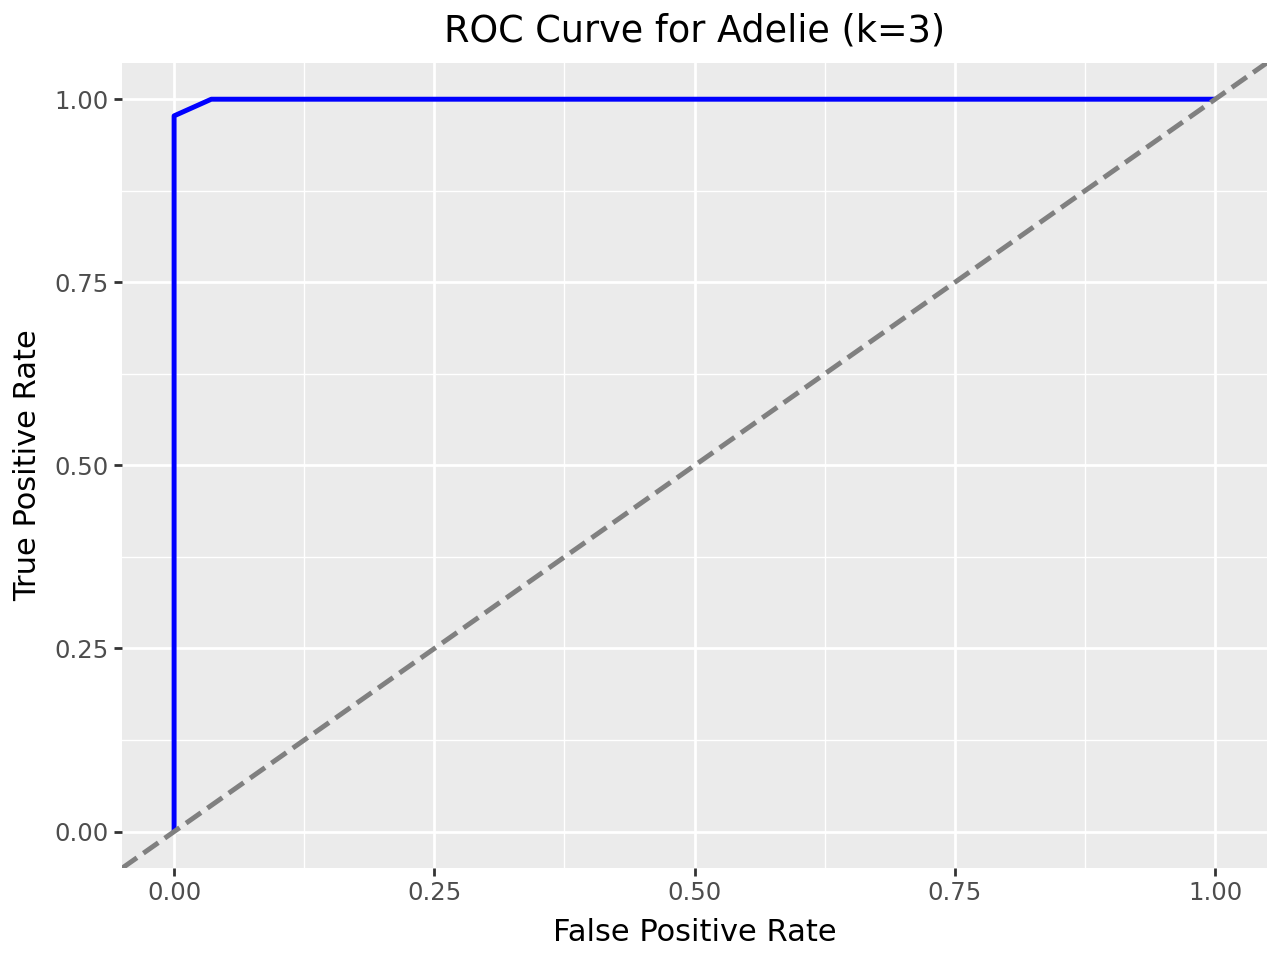

In [86]:
# ROC plot for Adelie
species_index = 0
species_name = classes[species_index]

# Calculate FPR, TPR, and AUC for Adelie
fpr, tpr, _ = roc_curve(y_test_binarized[:, species_index], y_prob_test_knn3[:, species_index])
roc_auc = auc(fpr, tpr)

# Create a DataFrame for Plotnine
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
})

(ggplot(roc_df, aes(x='False Positive Rate', y='True Positive Rate')) +
    geom_line(color='blue', size=1) +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='gray', size=1) +
    labs(
        title='ROC Curve for Adelie (k=3)',
        x='False Positive Rate',
        y='True Positive Rate')
)



This plot shows the ROC curve for the Adelie species using the kNN model with k=3. The curve illustrates how well the model distinguishes between the positive class (Adelie) and the others. The near-perfect AUC indicates excellent discrimination ability for predicting Adelie species with this model.